In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier,\
      GradientBoostingClassifier, StackingClassifier, VotingClassifier
import json
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay


## 数据处理部分

In [2]:
data = pd.read_pickle("data/data_processed_all_unscaled.pkl")
X_orig = data.drop(columns=['Number of nights in CITY', 'Purpose of visit to CITY']).to_numpy()
y = data['Purpose of visit to CITY'].to_numpy()

In [3]:
print(X_orig.shape)

(72370, 386)


In [4]:
ss = np.load('data/outliers_unscaled.npz')
outliers = ss['outliers'].astype(int)
rows_to_remove = outliers
X_orig = np.delete(X_orig, rows_to_remove, axis=0)
y = np.delete(y, rows_to_remove)

In [5]:
print(X_orig.shape)

(72361, 386)


In [6]:
pca_50 = PCA(n_components= 50)  
X_pca_50 = pca_50.fit_transform(X_orig)

pca_100 = PCA(n_components= 100)  
X_pca_100 = pca_100.fit_transform(X_orig)

pca_200 = PCA(n_components= 200)  
X_pca_200 = pca_200.fit_transform(X_orig)

In [7]:
lda = LDA(n_components=min(len(np.unique(y)) - 1, X_orig.shape[1]))
X_lda = lda.fit_transform(X_orig, y)

In [8]:
print(X_orig.shape)
print(X_lda.shape)

(72361, 386)
(72361, 3)


In [ ]:
select_50 = SelectKBest(k=50)
X_selected_50 = select_50.fit_transform(X_orig, y)

select_100 = SelectKBest(k=100)
X_selected_100 = select_100.fit_transform(X_orig, y)

select_200 = SelectKBest(k=200)
X_selected_200 = select_200.fit_transform(X_orig, y)

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

In [8]:
feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'LDA': X_lda,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200),
    'Scaled_LDA': StandardScaler().fit_transform(X_lda),
}

In [24]:
# 定义一个绘图函数
def classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title):
    if row_title == "Confusion Matrix":
        cm = confusion_matrix(y_clf_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4])
        disp.plot(ax=ax, cmap="viridis", colorbar=False)
        ax.set_title("Confusion Matrix")
    elif row_title == "ROC Curve":
        for class_idx in range(1, y_proba.shape[1] + 1):
            RocCurveDisplay.from_predictions(
                y_clf_test == class_idx, y_proba[:, class_idx - 1], ax=ax, name=f"Class {class_idx}"
            )
        ax.set_title("ROC Curve")

row_titles = ["Confusion Matrix", "ROC Curve"]

## Logistic Regression

Processing Folds: 0it [00:00, ?it/s]d:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Processing Folds: 1it [01:06, 66.98s/it]d:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Processing Folds: 5it [11:48, 141.79s/it]




Logistic Regression- - Fold 0 - Accuracy: 0.8768, Precision: 0.8679, Recall: 0.8768, F1: 0.8681, AUC: 0.9501
Logistic Regression- - Fold 1 - Accuracy: 0.8732, Precision: 0.8636, Recall: 0.8732, F1: 0.8663, AUC: 0.9476
Logistic Regression- - Fold 2 - Accuracy: 0.8777, Precision: 0.8694, Recall: 0.8777, F1: 0.8697, AUC: 0.9495
Logistic Regression- - Fold 3 - Accuracy: 0.8903, Precision: 0.8820, Recall: 0.8903, F1: 0.8833, AUC: 0.9537
Logistic Regression- - Fold 4 - Accuracy: 0.8836, Precision: 0.8743, Recall: 0.8836, F1: 0.8749, AUC: 0.9539


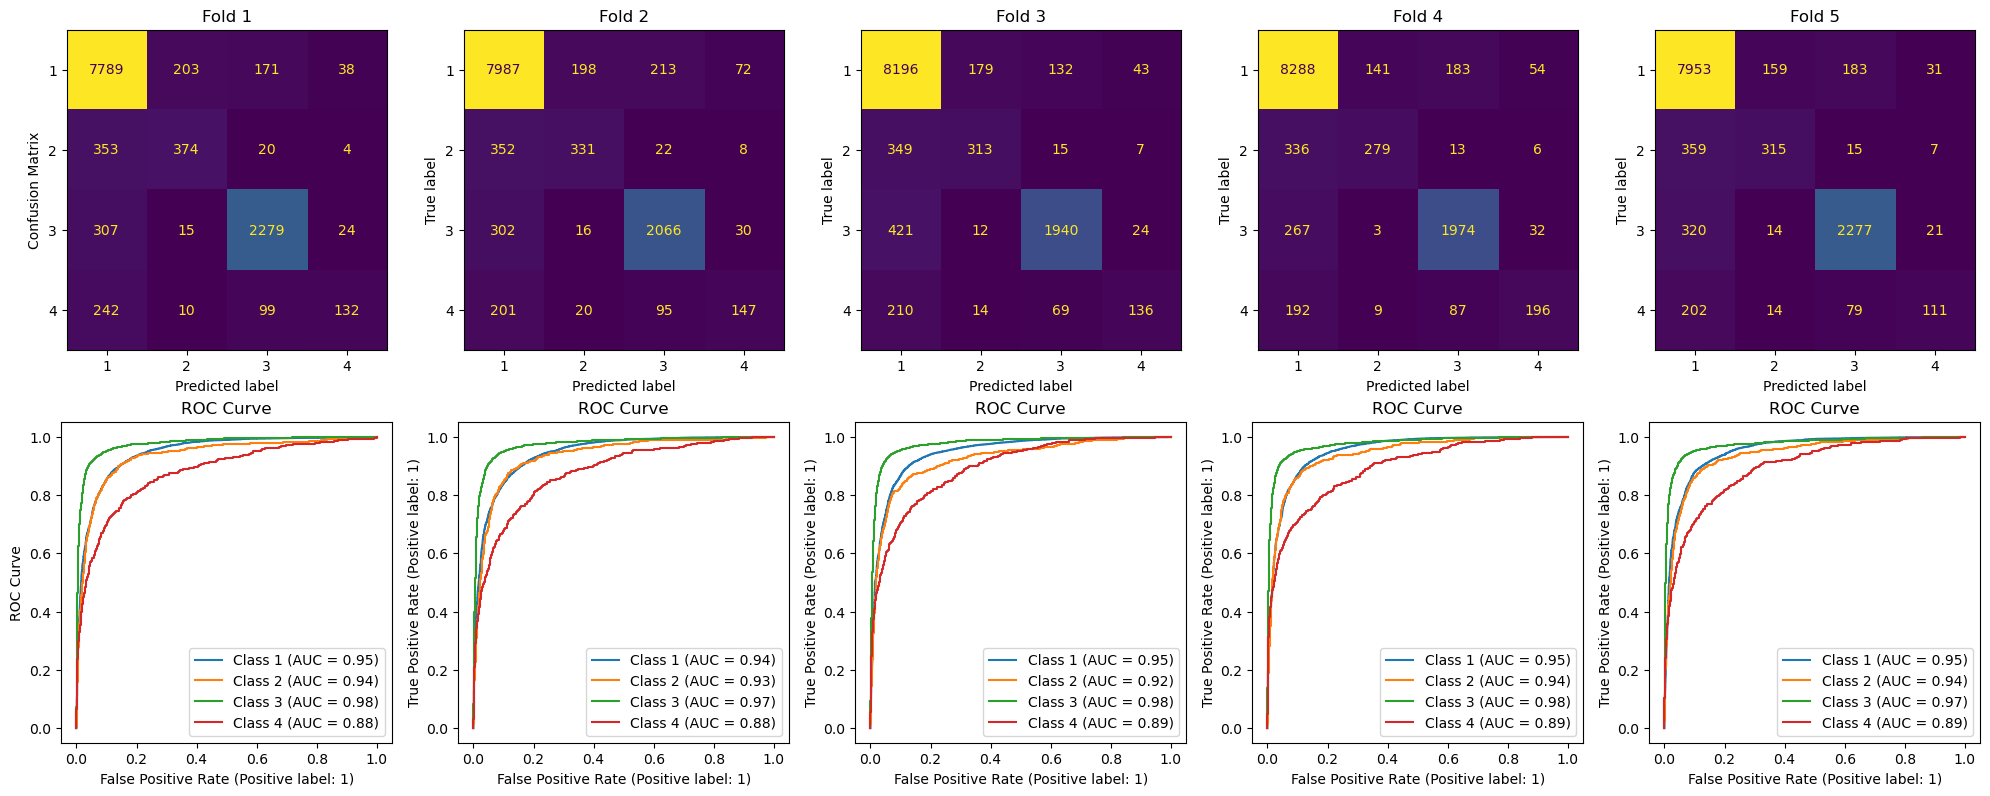

In [25]:
Logistic_Reg_params = {
    'C': [0.01, 0.1, 1.0, 5]
}
name = 'Logistic Regression'

X = feature_sets['Scaled_Select200Best']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # 定义和训练模型
    model = LogisticRegression(max_iter=1000, solver="saga", n_jobs=20)
    grid = GridSearchCV(model, Logistic_Reg_params, cv=2, n_jobs=20)
    grid.fit(X_train, y_clf_train)
    model = grid.best_estimator_

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()


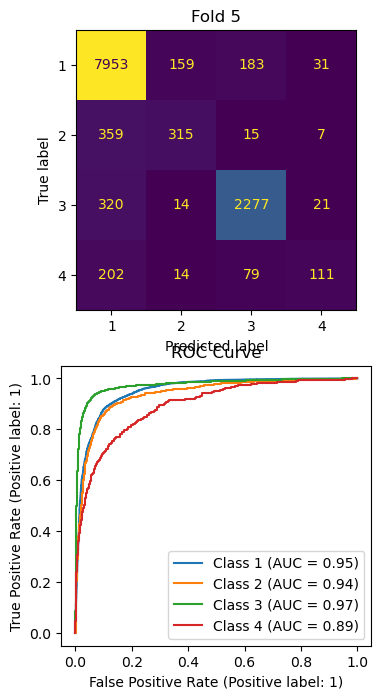

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(4, 8))

for row, row_title in enumerate(row_titles):
        ax = axes[row]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

plt.show()


Class 1 AUC: 0.9515225567755115


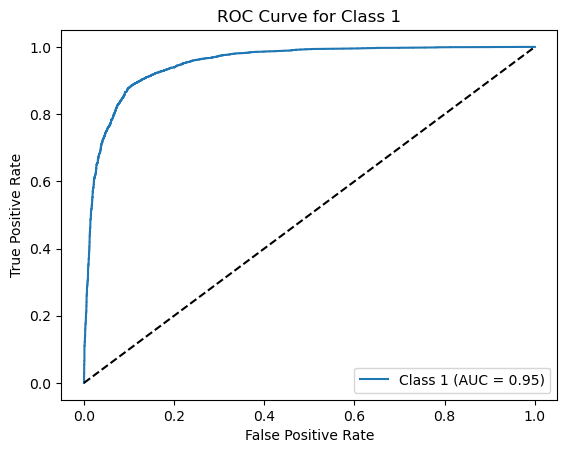

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_idx = 1  # 替换为你有问题的类别
y_true_binary = (y_clf_test == class_idx).astype(int)
y_score = y_proba[:, class_idx - 1]

fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
roc_auc = auc(fpr, tpr)
print(f"Class {class_idx} AUC: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {class_idx}')
plt.legend(loc='best')
plt.show()

## Decision Tree

Processing Folds: 5it [00:04,  1.01it/s]




Decision Tree- - Fold 0 - Accuracy: 0.8233, Precision: 0.8238, Recall: 0.8233, F1: 0.8235, AUC: 0.8252
Decision Tree- - Fold 1 - Accuracy: 0.8368, Precision: 0.8366, Recall: 0.8368, F1: 0.8366, AUC: 0.8320
Decision Tree- - Fold 2 - Accuracy: 0.8281, Precision: 0.8318, Recall: 0.8281, F1: 0.8299, AUC: 0.8226
Decision Tree- - Fold 3 - Accuracy: 0.8310, Precision: 0.8352, Recall: 0.8310, F1: 0.8330, AUC: 0.8253
Decision Tree- - Fold 4 - Accuracy: 0.8272, Precision: 0.8283, Recall: 0.8272, F1: 0.8277, AUC: 0.8232


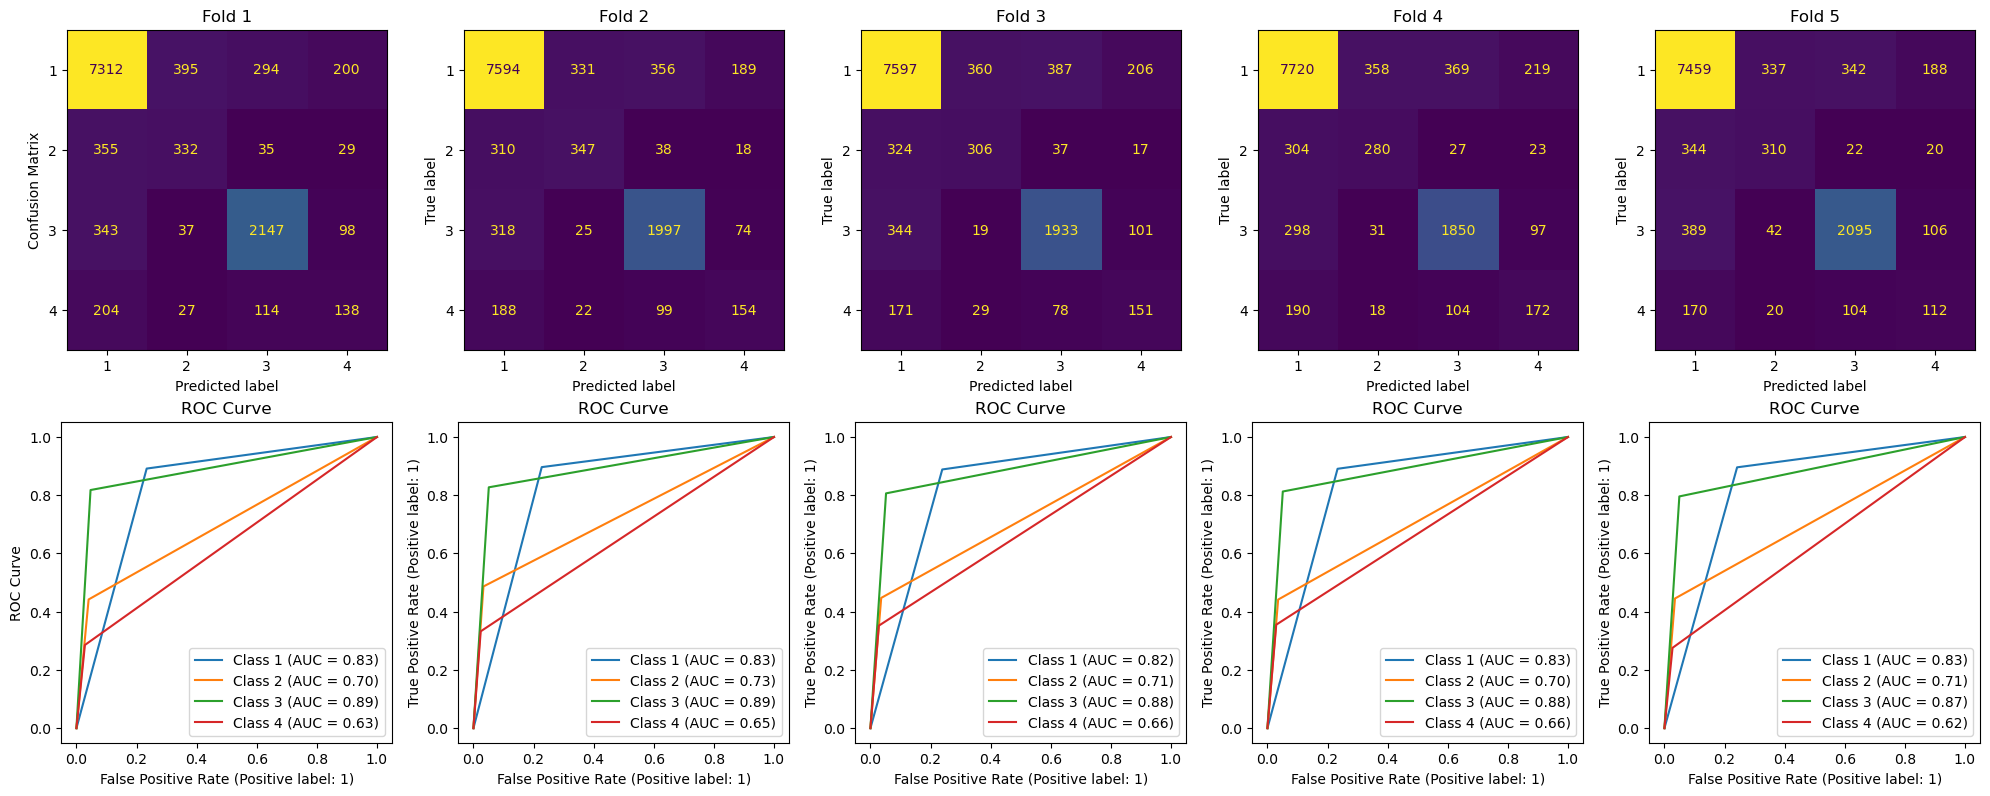

In [26]:
Decision_Tree_params = {
    'max_depth': [50, 100, 200]
    }
name = 'Decision Tree'

X = feature_sets['LDA']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # Define and train model with GridSearchCV
    model = DecisionTreeClassifier()
    grid = GridSearchCV(model, Decision_Tree_params, cv=2, n_jobs=20)
    grid.fit(X_train, y_clf_train)
    model = grid.best_estimator_

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## SVC

Processing Folds: 0it [00:00, ?it/s]

[LibSVM]

Processing Folds: 1it [00:11, 11.93s/it]

[LibSVM]

Processing Folds: 2it [01:25, 47.95s/it]

[LibSVM]

Processing Folds: 3it [04:23, 107.74s/it]

[LibSVM]

Processing Folds: 4it [06:42, 120.06s/it]

[LibSVM]

Processing Folds: 5it [09:49, 117.98s/it]




SVC- - Fold 0 - Accuracy: 0.8755, Precision: 0.8696, Recall: 0.8755, F1: 0.8626, AUC: 0.9309
SVC- - Fold 1 - Accuracy: 0.8686, Precision: 0.8557, Recall: 0.8686, F1: 0.8563, AUC: 0.9166
SVC- - Fold 2 - Accuracy: 0.8833, Precision: 0.8745, Recall: 0.8833, F1: 0.8736, AUC: 0.9260
SVC- - Fold 3 - Accuracy: 0.8857, Precision: 0.8782, Recall: 0.8857, F1: 0.8774, AUC: 0.9140
SVC- - Fold 4 - Accuracy: 0.8783, Precision: 0.8686, Recall: 0.8783, F1: 0.8689, AUC: 0.9127


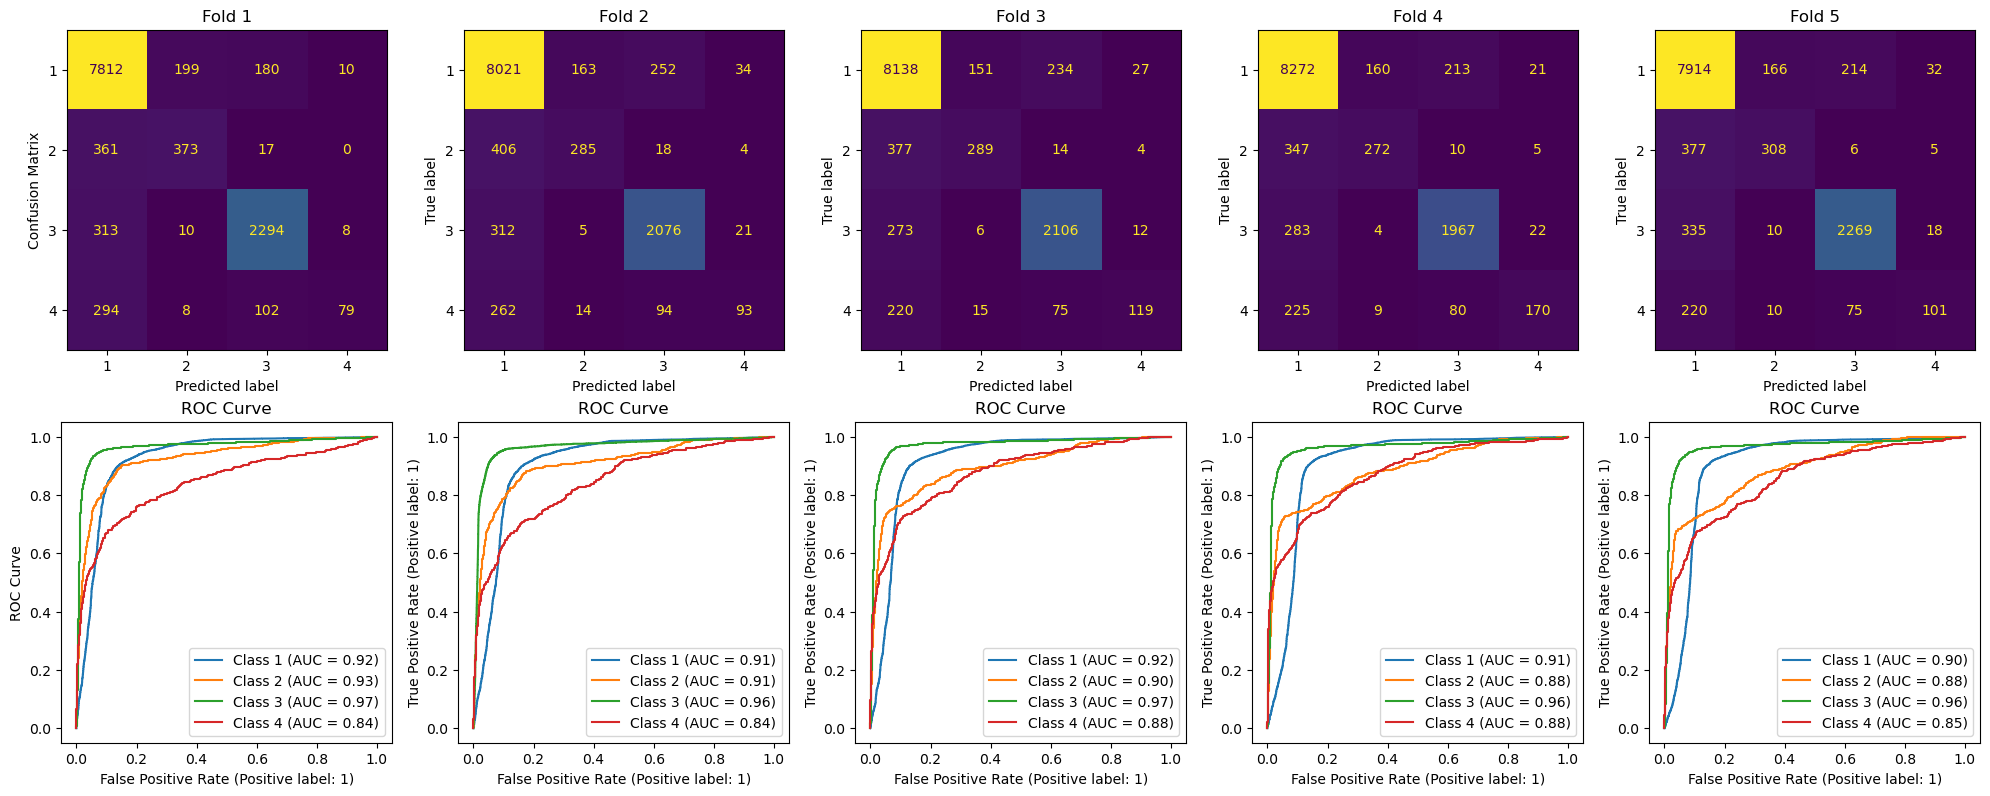

In [27]:
name = 'SVC'

X = feature_sets['Scaled_LDA']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # Define and train model with GridSearchCV
    model = SVC(verbose=1, probability=True, C=0.1, kernel='rbf')
    model.fit(X_train, y_clf_train)

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()

# 集成算法

## Random Forest

Processing Folds: 5it [02:15, 27.14s/it]




Random Forest- - Fold 0 - Accuracy: 0.8692, Precision: 0.8719, Recall: 0.8692, F1: 0.8426, AUC: 0.9510
Random Forest- - Fold 1 - Accuracy: 0.9153, Precision: 0.9181, Recall: 0.9153, F1: 0.9057, AUC: 0.9799
Random Forest- - Fold 2 - Accuracy: 0.8638, Precision: 0.8638, Recall: 0.8638, F1: 0.8441, AUC: 0.9503
Random Forest- - Fold 3 - Accuracy: 0.8873, Precision: 0.8834, Recall: 0.8873, F1: 0.8701, AUC: 0.9558
Random Forest- - Fold 4 - Accuracy: 0.8810, Precision: 0.8769, Recall: 0.8810, F1: 0.8625, AUC: 0.9544


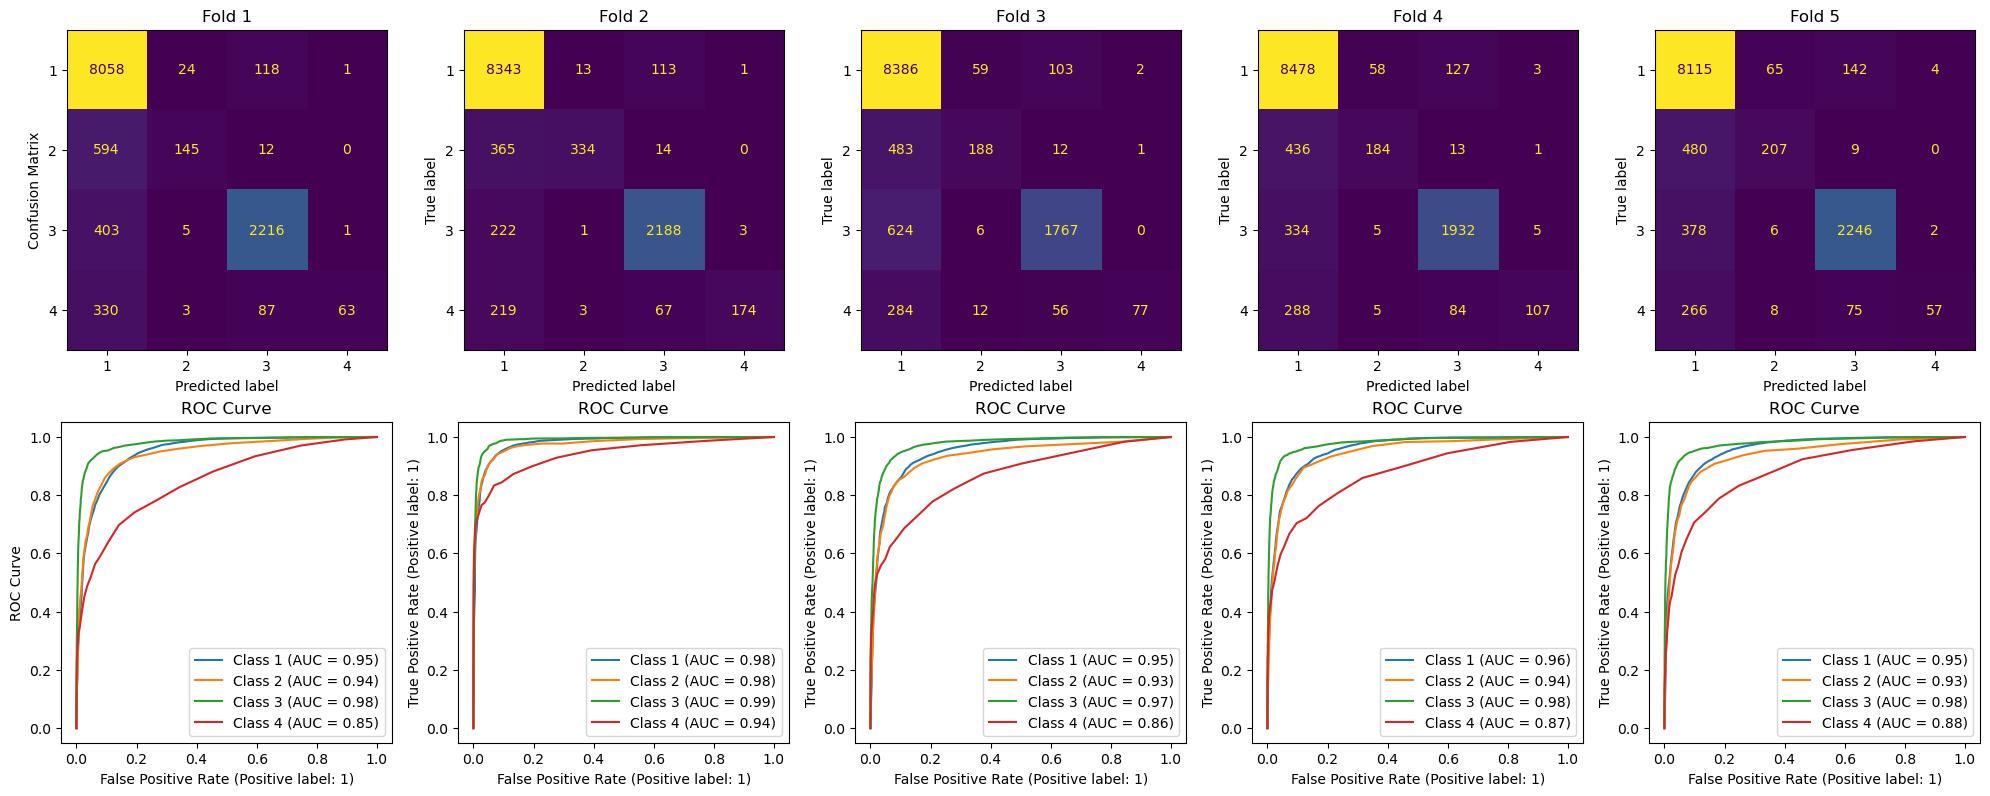

In [28]:
rf_params = {
    'n_estimators': [50, 100], 
    'max_depth': [100, 200]
    }
name = 'Random Forest'

X = feature_sets['Original']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # Define and train model with GridSearchCV
    model = RandomForestClassifier()
    grid = GridSearchCV(model, rf_params, cv=2)
    grid.fit(X_train, y_clf_train)
    model = grid.best_estimator_

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## Bagging Method

Processing Folds: 5it [00:19,  3.89s/it]




Bagging- - Fold 0 - Accuracy: 0.8711, Precision: 0.8621, Recall: 0.8711, F1: 0.8635, AUC: 0.9465
Bagging- - Fold 1 - Accuracy: 0.8775, Precision: 0.8679, Recall: 0.8775, F1: 0.8693, AUC: 0.9506
Bagging- - Fold 2 - Accuracy: 0.8789, Precision: 0.8705, Recall: 0.8789, F1: 0.8705, AUC: 0.9492
Bagging- - Fold 3 - Accuracy: 0.8904, Precision: 0.8821, Recall: 0.8904, F1: 0.8839, AUC: 0.9534
Bagging- - Fold 4 - Accuracy: 0.8833, Precision: 0.8735, Recall: 0.8833, F1: 0.8746, AUC: 0.9537


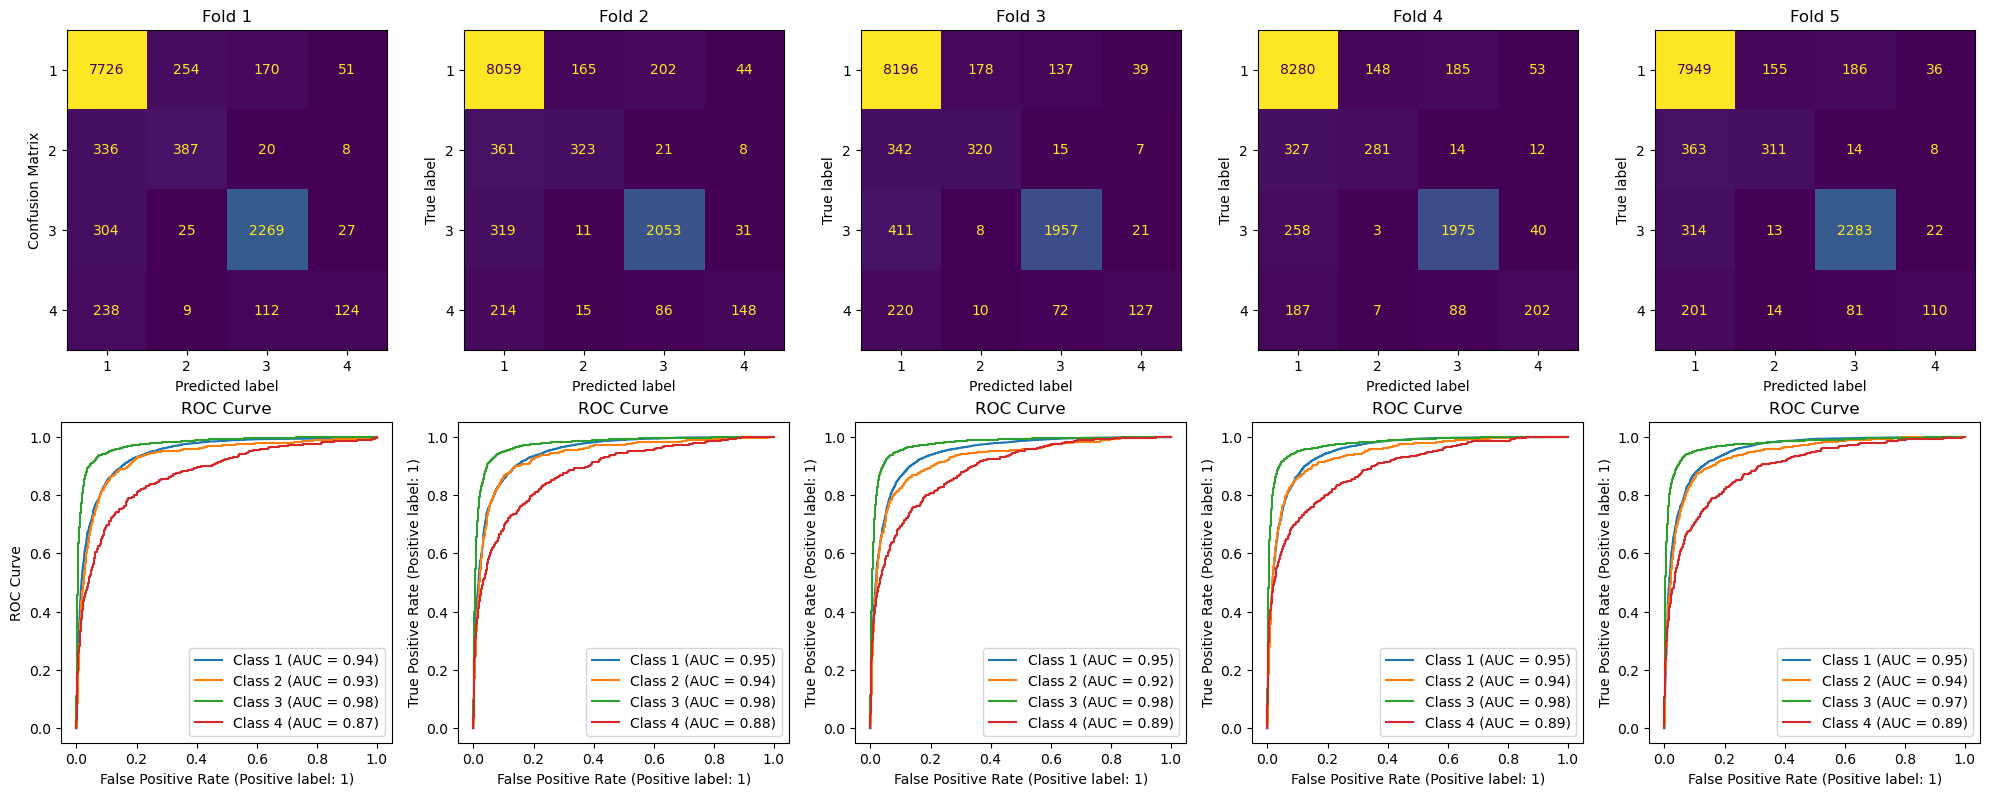

In [29]:
name = 'Bagging'

X = feature_sets['Scaled_Select200Best']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # Define and train model with GridSearchCV
    model = BaggingClassifier(estimator=LogisticRegression(C=0.1), n_estimators=10, random_state=42, n_jobs=20)
    model.fit(X_train, y_clf_train)

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## Voting

Processing Folds: 5it [08:05, 97.15s/it] 




Voting- - Fold 0 - Accuracy: 0.8753, Precision: 0.8647, Recall: 0.8753, F1: 0.8656, AUC: 0.9510
Voting- - Fold 1 - Accuracy: 0.8770, Precision: 0.8659, Recall: 0.8770, F1: 0.8665, AUC: 0.9459
Voting- - Fold 2 - Accuracy: 0.8840, Precision: 0.8748, Recall: 0.8840, F1: 0.8755, AUC: 0.9510
Voting- - Fold 3 - Accuracy: 0.8858, Precision: 0.8769, Recall: 0.8858, F1: 0.8778, AUC: 0.9496
Voting- - Fold 4 - Accuracy: 0.8789, Precision: 0.8680, Recall: 0.8789, F1: 0.8697, AUC: 0.9485


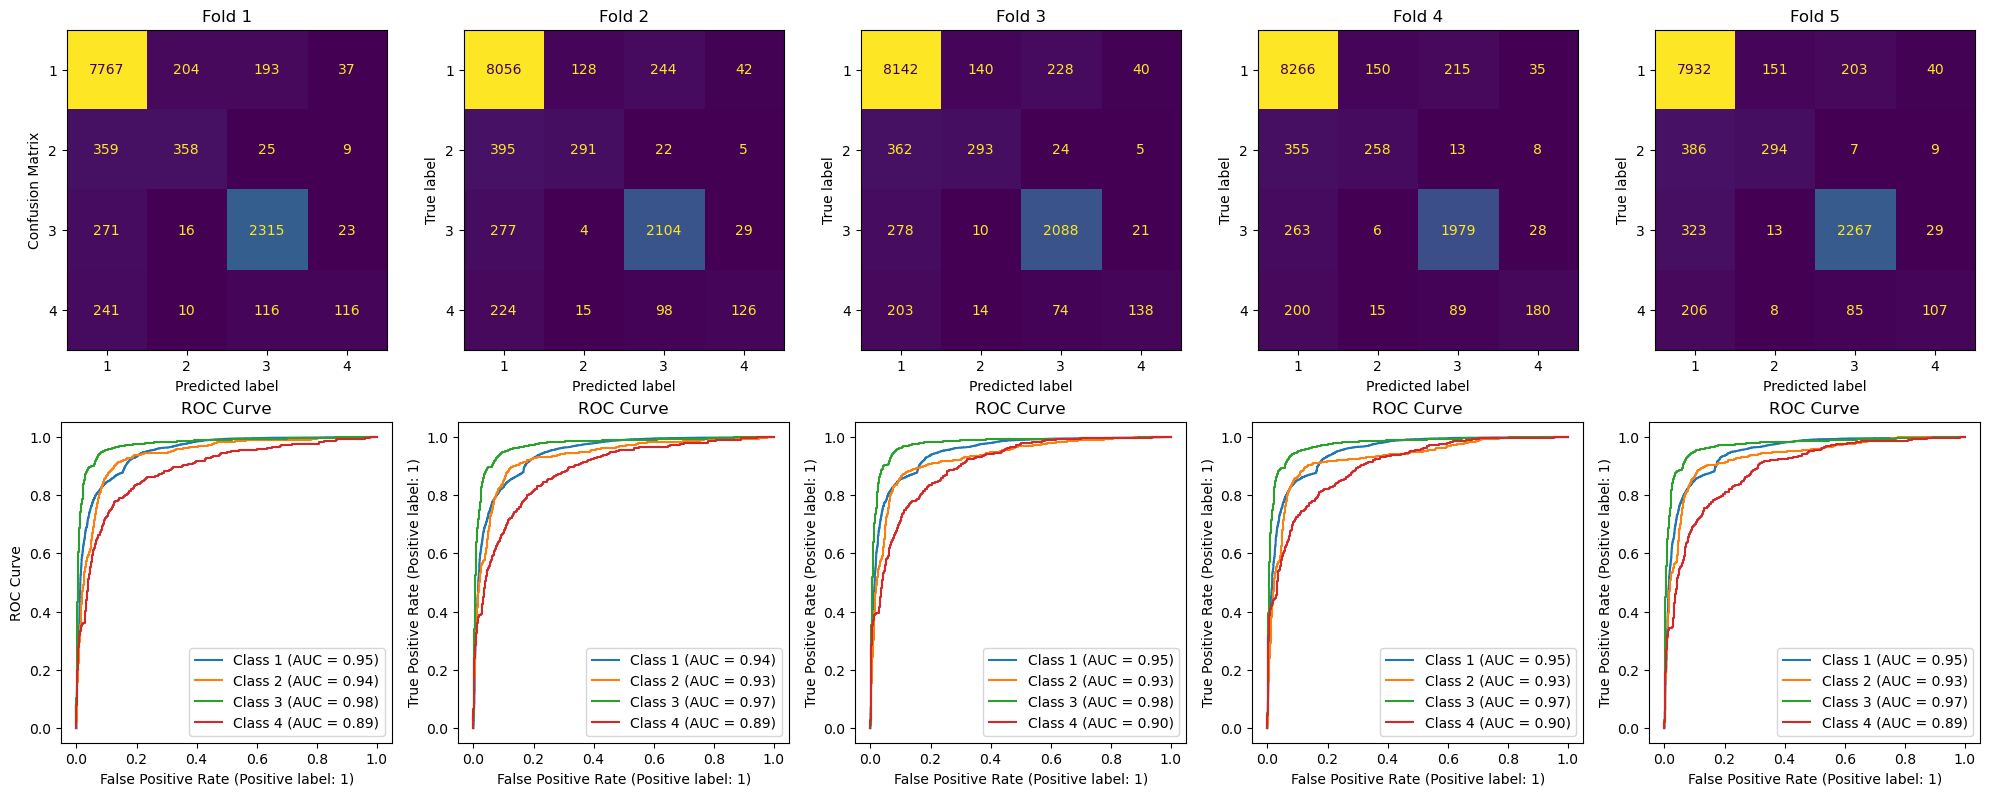

In [30]:
name = 'Voting'

estimators = [
    ('dt', DecisionTreeClassifier(max_depth=200)),
    ('svc', SVC(probability=True)), 
    ('LogisticRegression', LogisticRegression(C=0.5))
]

X = feature_sets['Scaled_LDA']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

results = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc="Processing Folds")):
    X_train, X_test = X[train_idx], X[test_idx]
    y_clf_train, y_clf_test = y[train_idx], y[test_idx]

    # Define and train model with GridSearchCV
    model = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)  # 'hard' for majority voting
    model.fit(X_train, y_clf_train)

    # 预测和计算指标
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

    fold_result = {
            'fold': fold,
            'accuracy': float(accuracy_score(y_clf_test, y_pred)),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
    }

    # Print per-fold results
    results.append(f'{name}- - Fold {fold} - Accuracy: {fold_result["accuracy"]:.4f}, '
              f'Precision: {fold_result["precision"]:.4f}, Recall: {fold_result["recall"]:.4f}, '
              f'F1: {fold_result["f1"]:.4f}, AUC: {fold_result["auc"]:.4f}')
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        classification_visualization_subplot(ax, y_clf_test, y_pred, y_proba, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

print('\n')

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## Blending

In [31]:
# name = 'Blending'

# estimators = [
#     ('dt', DecisionTreeClassifier(max_depth=200)),
#     ('svc', SVC(probability=True)), 
#     ('LogisticRegression', LogisticRegression(C=0.5))
# ]

# feature_sets = {
#     'Original': X_orig,
#     'PCA_50': X_pca_50,
#     'PCA_100': X_pca_100,
#     'PCA_200': X_pca_200,
#     'Select50Best': X_selected_50,
#     'Select100Best': X_selected_100,
#     'Select200Best': X_selected_200,
#     'LDA': X_lda,
#     'Scaled_Original': StandardScaler().fit_transform(X_orig),
#     'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
#     'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
#     'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
#     'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
#     'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
#     'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200),
#     'Scaled_LDA': StandardScaler().fit_transform(X_lda),
# }

# # Dictionary to store results for all feature sets
# results = {
#     'model_name': name,
#     'feature_sets': {}
# }

# for feature_name, X in feature_sets.items():
#     # Lists to store metrics and model parameters for each fold
#     fold_metrics = []
    
#     for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X), desc=f'Processing {feature_name}')):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_clf_train, y_clf_test = y[train_idx], y[test_idx]
        
#         X_base_train, X_meta_train, y_base_train, y_meta_train = train_test_split(
#             X_train, y_clf_train, test_size=0.2, random_state=42)

#         # 基础模型训练
#         base_model1 = DecisionTreeClassifier(max_depth=200)
#         base_model2 = LogisticRegression(max_iter=1000)
#         base_model1.fit(X_base_train, y_base_train)
#         base_model2.fit(X_base_train, y_base_train)

#         # 基础模型预测次级模型特征
#         pred1_meta = base_model1.predict_proba(X_meta_train)
#         pred2_meta = base_model2.predict_proba(X_meta_train)
#         blended_features_meta = np.hstack((pred1_meta, pred2_meta))

#         # 次级模型训练
#         meta_model = LogisticRegression(C=0.5)
#         meta_model.fit(blended_features_meta, y_meta_train)

#         # 基础模型在验证集预测
#         pred1 = base_model1.predict_proba(X_test)
#         pred2 = base_model2.predict_proba(X_test)
#         blended_features = np.hstack((pred1, pred2))

#         # 次级模型预测
#         y_pred = meta_model.predict(blended_features)
        
#         # Make predictions and compute metrics
#         y_pred = model.predict(X_test)
#         precision, recall, f1, _ = precision_recall_fscore_support(y_clf_test, y_pred, average='weighted', zero_division=1)
#         auc = roc_auc_score(y_clf_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
        
#         # Store fold metrics
#         fold_result = {
#             'fold': fold,
#             'accuracy': float(accuracy_score(y_clf_test, y_pred)),
#             'precision': float(precision),
#             'recall': float(recall),
#             'f1': float(f1),
#             'auc': float(auc)
#         }
#         fold_metrics.append(fold_result)
                        
#         # Print per-fold results
#         print(f'{name}-{feature_name} - Fold {fold} - Accuracy: {fold_result["accuracy"]:.2f}, '
#               f'Precision: {fold_result["precision"]:.2f}, Recall: {fold_result["recall"]:.2f}, '
#               f'F1: {fold_result["f1"]:.2f}, AUC: {fold_result["auc"]:.2f}')
    
#     # Compute average metrics across folds
#     avg_metrics = {
#         'avg_accuracy': float(np.mean([m['accuracy'] for m in fold_metrics])),
#         'avg_precision': float(np.mean([m['precision'] for m in fold_metrics])),
#         'avg_recall': float(np.mean([m['recall'] for m in fold_metrics])),
#         'avg_f1': float(np.mean([m['f1'] for m in fold_metrics])),
#         'avg_auc': float(np.mean([m['auc'] for m in fold_metrics]))
#     }
    
#     # Store results for this feature set
#     results['feature_sets'][feature_name] = {
#         'fold_metrics': fold_metrics,
#         'average_metrics': avg_metrics
#     }
    
#     # Print average results
#     print(f'\nAverage Performance Across Folds for {feature_name}:')
#     print(f'{name}-{feature_name} - Accuracy: {avg_metrics["avg_accuracy"]:.2f}, '
#           f'Precision: {avg_metrics["avg_precision"]:.2f}, Recall: {avg_metrics["avg_recall"]:.2f}, '
#           f'F1: {avg_metrics["avg_f1"]:.2f}, AUC: {avg_metrics["avg_auc"]:.2f}\n')

# # Save results to JSON file
# with open(f'results/clf_aug/{name}_results.json', 'w') as f:
#     json.dump(results, f, indent=4)

# print("Results and model parameters have been saved to 'logistic_regression_results.json'")